In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import umap
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from datetime import timedelta
from scipy.stats import wasserstein_distance

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Load Prep Data

In [3]:
seeds = [1415, 9265, 3589, 7932, 3846, 2643, 3832, 7950, 2884, 1971]
seed_index = 9  # Change this value (0, 1, 2, etc.) for different seeds

current_seed = seeds[seed_index]

print(f"Using Preprocessing-Seed {seed_index}: {current_seed}")

Using Preprocessing-Seed 9: 1971


In [4]:
df_original = pd.read_csv(f'/Users/fabian/Downloads/MasterDegree/df_train_{current_seed}.csv')

display(df_original)
unique_vessel_groups_train = df_original['VesselGroup'].unique()
num_vessel_groups_train = df_original['VesselGroup'].nunique()
print(f"There are {num_vessel_groups_train} unique vessel groups.")
print(f"The unique vessel types groups: {unique_vessel_groups_train}")

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,538005775.1,2023-05-05 21:39:27,29.747110,-95.098320,0.600000,270.200000,NAVIG8 ANDESINE,Tanker
1,538005775.1,2023-05-05 21:41:27,29.747296,-95.098903,0.938028,286.171831,NAVIG8 ANDESINE,Tanker
2,538005775.1,2023-05-05 21:43:27,29.747502,-95.099658,1.302381,283.942381,NAVIG8 ANDESINE,Tanker
3,538005775.1,2023-05-05 21:45:27,29.747463,-95.100071,0.419772,190.295437,NAVIG8 ANDESINE,Tanker
4,538005775.1,2023-05-05 21:47:27,29.748040,-95.099394,2.319033,88.353172,NAVIG8 ANDESINE,Tanker
...,...,...,...,...,...,...,...,...
200253,311263000.4,2023-09-23 10:07:50,26.087573,-80.118574,0.734690,183.877168,ADVENTURE OFTHE SEAS,Passenger
200254,311263000.4,2023-09-23 10:09:50,26.087352,-80.117670,0.471329,200.623077,ADVENTURE OFTHE SEAS,Passenger
200255,311263000.4,2023-09-23 10:11:50,26.087212,-80.117176,0.295261,159.605863,ADVENTURE OFTHE SEAS,Passenger
200256,311263000.4,2023-09-23 10:13:50,26.087236,-80.115827,0.252927,132.876412,ADVENTURE OFTHE SEAS,Passenger


There are 3 unique vessel groups.
The unique vessel types groups: ['Tanker' 'Tug' 'Passenger']


# k-Means Augmentation

In [5]:
def augment_ais_data_with_balanced_groups(df, num_augmented_rows, time_gap_minutes):
    """
    Augments AIS data to generate a specified total number of augmented rows balanced across VesselGroups.

    Parameters:
        df (DataFrame): Original AIS data with numeric and non-numeric columns.
        num_augmented_rows (int): Total number of augmented rows to generate.
        time_gap_minutes (int): Time gap in minutes between consecutive points in a trajectory.

    Returns:
        DataFrame: Augmented dataset with the specified total number of rows.
    """
    augmented_data = []
    numeric_features = ['LAT', 'LON', 'SOG', 'COG']
    kmeans = KMeans(n_clusters=10, random_state=42)
    
    df_numeric = df.dropna(subset=numeric_features)
    kmeans.fit(df_numeric[numeric_features])
    centroids = kmeans.cluster_centers_

    vessel_groups = df['VesselGroup'].dropna().unique()
    rows_per_group = num_augmented_rows // len(vessel_groups)

    existing_mmsi = set(df['MMSI'].dropna())
    generated_mmsi = set()

    def generate_unique_mmsi():
        while True:
            new_mmsi = f"{random.randint(100000000, 999999999)}.{random.randint(1, 9)}"
            if new_mmsi not in existing_mmsi and new_mmsi not in generated_mmsi:
                generated_mmsi.add(new_mmsi)
                return new_mmsi

    for vessel_group in vessel_groups:
        group_rows_generated = 0

        group_data = df[df['VesselGroup'] == vessel_group]
        
        if group_data.empty:
            print(f"Warning: VesselGroup '{vessel_group}' has no data to augment.")
            continue

        while group_rows_generated < rows_per_group:
            cluster_idx = random.randint(0, len(centroids) - 1)
            centroid = centroids[cluster_idx]

            sequence_length = random.randint(40, 60)
            perturbations = np.random.normal(scale=0.01, size=(sequence_length, len(numeric_features)))
            trajectory_points = centroid + perturbations

            valid_datetimes = group_data['BaseDateTime'].dropna().values
            if len(valid_datetimes) == 0:
                print(f"Warning: No valid BaseDateTime values for VesselGroup '{vessel_group}'.")
                break
            
            start_time = pd.to_datetime(random.choice(valid_datetimes))
            base_times = [start_time + timedelta(minutes=j * time_gap_minutes) for j in range(sequence_length)]

            new_mmsi = generate_unique_mmsi()

            for j in range(sequence_length):
                augmented_data.append({
                    'MMSI': new_mmsi,
                    'BaseDateTime': base_times[j],
                    'LAT': trajectory_points[j][0],
                    'LON': trajectory_points[j][1],
                    'SOG': trajectory_points[j][2],
                    'COG': trajectory_points[j][3],
                    'VesselGroup': vessel_group,
                    'VesselName': f"Augmented_{new_mmsi}"
                })
            
            group_rows_generated += sequence_length

        print(f"Generated {group_rows_generated} rows for VesselGroup '{vessel_group}'.")

    return pd.DataFrame(augmented_data[:num_augmented_rows])

In [6]:
augmentation_sizes = [50000, 100000, 150000, 200000]
time_gap_minutes = 2

In [7]:
combined_dfs = {}

quantitative_results = []

for num_augmented_rows in augmentation_sizes:
    print(f"\nGenerating augmented data with {num_augmented_rows} rows (balanced across VesselGroups)...")
    
    df_augmented = augment_ais_data_with_balanced_groups(df_original, num_augmented_rows, time_gap_minutes)
    df_augmented['source'] = 'Augmented'
    
    df_original['source'] = 'Original'
    combined_df = pd.concat([df_original, df_augmented], ignore_index=True)
    combined_dfs[f'combined_{num_augmented_rows}'] = combined_df

    
    """
    # Select numeric features for dimensionality reduction
    features = ['LAT', 'LON', 'SOG', 'COG']
    X = combined_df[features]
    y = combined_df['source']  # Label to distinguish between original and augmented data

    # Apply UMAP
    print(f"Applying UMAP for visualization...")
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    X_umap = umap_reducer.fit_transform(X)

    # Add reduced dimensions back to the dataset
    combined_df['umap_dim1'], combined_df['umap_dim2'] = X_umap[:, 0], X_umap[:, 1]

    # Quantitative Comparison: Wasserstein Distance
    df_original_umap = combined_df[combined_df['source'] == 'Original']
    df_augmented_umap = combined_df[combined_df['source'] == 'Augmented']
    wd_dim1 = wasserstein_distance(df_original_umap['umap_dim1'], df_augmented_umap['umap_dim1'])
    wd_dim2 = wasserstein_distance(df_original_umap['umap_dim2'], df_augmented_umap['umap_dim2'])
    print(f"Wasserstein Distance (Dimension 1): {wd_dim1}")
    print(f"Wasserstein Distance (Dimension 2): {wd_dim2}")
    quantitative_results.append({
        'num_augmented_rows': num_augmented_rows,
        'wasserstein_dim1': wd_dim1,
        'wasserstein_dim2': wd_dim2
    }) 

    # Plot UMAP results
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=combined_df, x='umap_dim1', y='umap_dim2', hue='source', alpha=0.5)
    plt.title(f"UMAP Visualization: Original vs Augmented (Rows: {num_augmented_rows})")
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show() """

quantitative_df = pd.DataFrame(quantitative_results)
print("\nQuantitative Results:")
display(quantitative_df)


Generating augmented data with 50000 rows (balanced across VesselGroups)...
Generated 16682 rows for VesselGroup 'Tanker'.
Generated 16667 rows for VesselGroup 'Tug'.
Generated 16694 rows for VesselGroup 'Passenger'.

Generating augmented data with 100000 rows (balanced across VesselGroups)...
Generated 33336 rows for VesselGroup 'Tanker'.
Generated 33379 rows for VesselGroup 'Tug'.
Generated 33370 rows for VesselGroup 'Passenger'.

Generating augmented data with 150000 rows (balanced across VesselGroups)...
Generated 50042 rows for VesselGroup 'Tanker'.
Generated 50009 rows for VesselGroup 'Tug'.
Generated 50021 rows for VesselGroup 'Passenger'.

Generating augmented data with 200000 rows (balanced across VesselGroups)...
Generated 66709 rows for VesselGroup 'Tanker'.
Generated 66674 rows for VesselGroup 'Tug'.
Generated 66687 rows for VesselGroup 'Passenger'.

Quantitative Results:


""


# Saving augmented Datasets

In [8]:
import os

def save_augmented_dataframes(combined_dfs, directory):
    """
    Saves the augmented data frames to a specified directory.

    Parameters:
        combined_dfs (dict): A dictionary where keys are names (e.g., 'combined_10000') 
                             and values are DataFrames to be saved.
        directory (str): The directory where the files will be saved.

    Returns:
        None
    """
    os.makedirs(directory, exist_ok=True)

    for key, df in combined_dfs.items():
        num_augmented_rows = key.split('_')[-1]
        file_name = f"df_kmeans_{num_augmented_rows}.csv"
        file_path = os.path.join(directory, file_name)

        df.to_csv(file_path, index=False)
        print(f"Saved {file_name} to {directory}")

output_directory = f"/Users/fabian/Downloads/MasterDegree/kmeans/kmeans{current_seed}" 
save_augmented_dataframes(combined_dfs, output_directory)

Saved df_kmeans_50000.csv to /Users/fabian/Downloads/MasterDegree/kmeans/kmeans1971
Saved df_kmeans_100000.csv to /Users/fabian/Downloads/MasterDegree/kmeans/kmeans1971
Saved df_kmeans_150000.csv to /Users/fabian/Downloads/MasterDegree/kmeans/kmeans1971
Saved df_kmeans_200000.csv to /Users/fabian/Downloads/MasterDegree/kmeans/kmeans1971


# Visualization

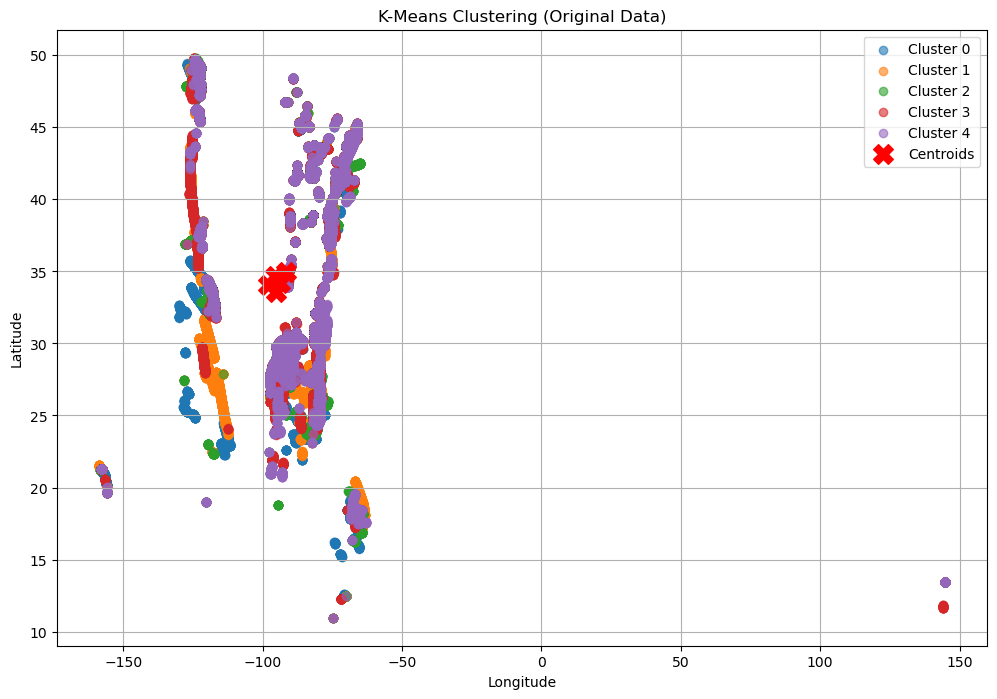

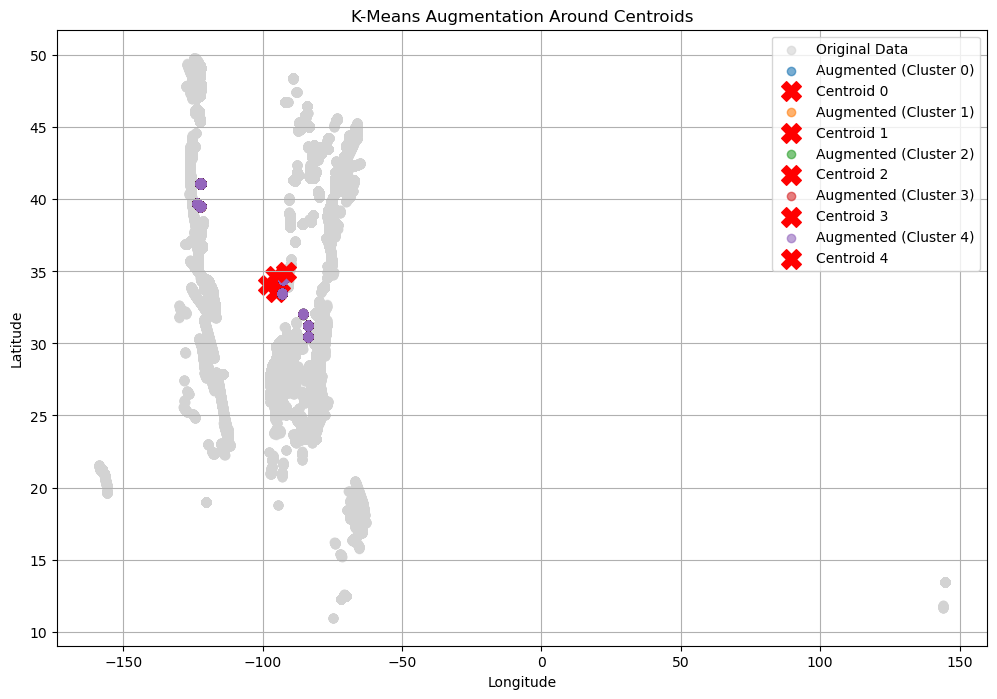

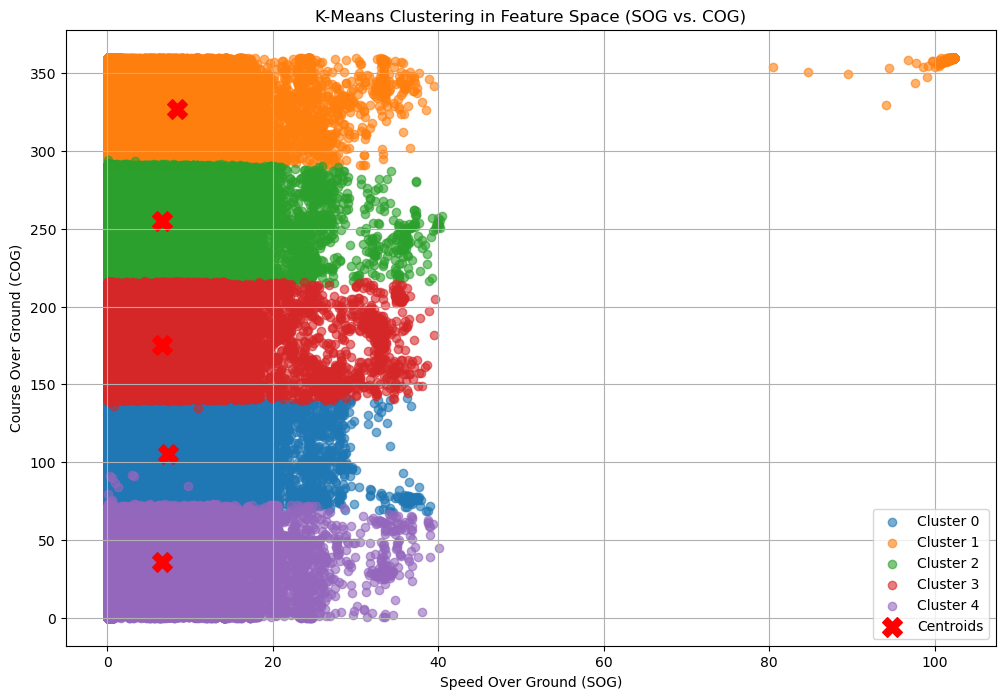

In [9]:
def visualize_kmeans_clustering(df, augmented_df, kmeans_model, numeric_features):
    """
    Generates K-Means-related plots to show clustering and augmentation.

    Parameters:
        df (DataFrame): Original dataset.
        augmented_df (DataFrame): Augmented dataset.
        kmeans_model (KMeans): Trained K-Means model.
        numeric_features (list): List of numeric feature names used in K-Means.
    """
    centroids = kmeans_model.cluster_centers_
    cluster_labels = kmeans_model.labels_

    plt.figure(figsize=(12, 8))
    for cluster in np.unique(cluster_labels):
        cluster_points = df.loc[cluster_labels == cluster, ['LAT', 'LON']]
        plt.scatter(
            cluster_points['LON'], cluster_points['LAT'], label=f'Cluster {cluster}', alpha=0.6
        )
    plt.scatter(centroids[:, 1], centroids[:, 0], c='red', s=200, label='Centroids', marker='X')
    plt.title('K-Means Clustering (Original Data)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.scatter(df['LON'], df['LAT'], c='lightgray', label='Original Data', alpha=0.6)
    for cluster, centroid in enumerate(centroids):
        cluster_augmented_points = augmented_df[augmented_df['Cluster'] == cluster]
        plt.scatter(
            cluster_augmented_points['LON'],
            cluster_augmented_points['LAT'],
            label=f'Augmented (Cluster {cluster})',
            alpha=0.6,
        )
        plt.scatter(centroid[1], centroid[0], c='red', s=200, marker='X', label=f'Centroid {cluster}')
    plt.title('K-Means Augmentation Around Centroids')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 8))
    for cluster in np.unique(cluster_labels):
        cluster_points = df.loc[cluster_labels == cluster, ['SOG', 'COG']]
        plt.scatter(
            cluster_points['SOG'], cluster_points['COG'], label=f'Cluster {cluster}', alpha=0.6
        )
    plt.scatter(centroids[:, 2], centroids[:, 3], c='red', s=200, label='Centroids', marker='X')
    plt.title('K-Means Clustering in Feature Space (SOG vs. COG)')
    plt.xlabel('Speed Over Ground (SOG)')
    plt.ylabel('Course Over Ground (COG)')
    plt.legend()
    plt.grid(True)
    plt.show()

numeric_features = ['LAT', 'LON', 'SOG', 'COG']
kmeans = KMeans(n_clusters=5, random_state=42)
df_original_numeric = df_original[numeric_features].dropna()
kmeans.fit(df_original_numeric)

df_original['Cluster'] = kmeans.labels_

df_augmented['Cluster'] = np.random.choice(kmeans.labels_, size=len(df_augmented))

visualize_kmeans_clustering(df_original, df_augmented, kmeans, numeric_features)